<a href="https://colab.research.google.com/github/dante77999/colab/blob/main/Transfer_Learning_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"

In [49]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [50]:
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

In [51]:
import torchvision

vit = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)

In [52]:
for params in vit.parameters():
    params.requires_grad = False

vit.heads = torch.nn.Sequential(
    torch.nn.Linear(in_features=768,out_features=3)
)

vit.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [53]:
from torchinfo import summary

summary(model=vit,
        input_size=(32,3,224,224),col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [57]:
#prepare data

from torch.utils.data import DataLoader
from torchvision import datasets

vit_transform = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1.transforms()
batch_size=16

train_dataset = datasets.ImageFolder(root=train_dir,transform=vit_transform)
test_dataset = datasets.ImageFolder(root=test_dir,transform=vit_transform)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True,
                              num_workers=1,
                              )

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False,
                             pin_memory=False,
                             num_workers=1)

class_names = train_dataset.classes

In [55]:
train_dataset.samples[123]

('data/pizza_steak_sushi/train/steak/2648423.jpg', 1)

In [60]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

In [62]:
#train process
from tqdm.auto import tqdm

loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=vit.parameters(),
                             lr=0.05)
epochs = 20
n = 0

results={
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
    }

for epoch in tqdm(range(epochs)):
    n+=1

    vit.train()

    train_loss,train_acc = 0, 0
    test_loss,test_acc = 0, 0

    #0. let dataloader to device
    for batch,(X,y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)
        #1. load the data to model

        y_train_pred_logit =  vit(X)

        #2. calculate the loss

        loss = loss_fn(y_train_pred_logit,y)
        train_loss+=loss.item()

        #3.optim zero grad

        optim.zero_grad()

        #4.backwards

        loss.backward()

        #5.optim step

        optim.step()

        #turn logit into prob
        y_train_prob = torch.argmax((torch.softmax(y_train_pred_logit,dim=1)),dim=1)
        train_acc = (y_train_prob==y).sum().item() / len(y)

    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)

    for batch,(X,y) in enumerate(test_dataloader):
        X = X.to(device)
        y = y.to(device)
        vit.eval()
        with torch.inference_mode():
            y_test_logit = vit(X)
            t_loss = loss_fn(y_test_logit,y)
            test_loss+=t_loss.item()

            #turn into pred

            y_test_pred = torch.argmax(torch.softmax(y_test_logit,dim=1),dim=1)
            test_acc = (y_test_pred==y).sum().item() / len(y)

    test_loss = test_loss / len(test_dataloader)
    test_acc = test_acc / len(test_dataloader)

    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)


    print(f"The {n} time train_loss is {train_loss:.4f} | train_acc is {train_acc:.4f} | test_loss is {test_loss:.4f} | test acc is {test_acc:.4f}")


  0%|          | 0/20 [00:00<?, ?it/s]

The 1 time train_loss is 0.9263 | train_acc is 0.0000 | test_loss is 2.8541 | test acc is 0.2424
The 2 time train_loss is 0.0863 | train_acc is 0.0667 | test_loss is 1.6973 | test acc is 0.3030
The 3 time train_loss is 0.1411 | train_acc is 0.0667 | test_loss is 1.9781 | test acc is 0.2727
The 4 time train_loss is 0.1505 | train_acc is 0.0667 | test_loss is 1.9281 | test acc is 0.2727
The 5 time train_loss is 0.0000 | train_acc is 0.0667 | test_loss is 2.0662 | test acc is 0.3030
The 6 time train_loss is 0.0242 | train_acc is 0.0667 | test_loss is 2.0932 | test acc is 0.3030
The 7 time train_loss is 0.0000 | train_acc is 0.0667 | test_loss is 2.1270 | test acc is 0.3030
The 8 time train_loss is 0.0000 | train_acc is 0.0667 | test_loss is 2.1602 | test acc is 0.2727
The 9 time train_loss is 0.0000 | train_acc is 0.0667 | test_loss is 2.1692 | test acc is 0.2727
The 10 time train_loss is 0.0000 | train_acc is 0.0667 | test_loss is 2.1713 | test acc is 0.2727
The 11 time train_loss is 0.0

Using device: cuda
可訓練參數: 2,307
總參數: 85,800,963
開始訓練...
訓練樣本數: 225
測試樣本數: 75
類別: ['pizza', 'steak', 'sushi']

Epoch 1/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.6646 | Train Acc: 0.7156 (71.56%)
Test Loss: 0.3893 | Test Acc: 0.8800 (88.00%)

Epoch 2/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.2314 | Train Acc: 0.9556 (95.56%)
Test Loss: 0.2447 | Test Acc: 0.9200 (92.00%)

Epoch 3/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.1443 | Train Acc: 0.9644 (96.44%)
Test Loss: 0.2304 | Test Acc: 0.9200 (92.00%)

Epoch 4/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.1199 | Train Acc: 0.9733 (97.33%)
Test Loss: 0.2159 | Test Acc: 0.9333 (93.33%)

Epoch 5/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0905 | Train Acc: 0.9822 (98.22%)
Test Loss: 0.2171 | Test Acc: 0.9467 (94.67%)

Epoch 6/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0736 | Train Acc: 0.9867 (98.67%)
Test Loss: 0.1996 | Test Acc: 0.9467 (94.67%)

Epoch 7/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x764fd3fac220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x764fd3fac220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Train Loss: 0.0603 | Train Acc: 0.9867 (98.67%)
Test Loss: 0.1967 | Test Acc: 0.9467 (94.67%)

Epoch 8/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0527 | Train Acc: 0.9911 (99.11%)
Test Loss: 0.2046 | Test Acc: 0.9467 (94.67%)

Epoch 9/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0442 | Train Acc: 0.9911 (99.11%)
Test Loss: 0.1972 | Test Acc: 0.9333 (93.33%)

Epoch 10/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0391 | Train Acc: 0.9956 (99.56%)
Test Loss: 0.1987 | Test Acc: 0.9333 (93.33%)

Epoch 11/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0330 | Train Acc: 1.0000 (100.00%)
Test Loss: 0.1943 | Test Acc: 0.9467 (94.67%)

Epoch 12/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0295 | Train Acc: 1.0000 (100.00%)
Test Loss: 0.1952 | Test Acc: 0.9333 (93.33%)

Epoch 13/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0273 | Train Acc: 1.0000 (100.00%)
Test Loss: 0.1970 | Test Acc: 0.9333 (93.33%)

Epoch 14/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0236 | Train Acc: 1.0000 (100.00%)
Test Loss: 0.1938 | Test Acc: 0.9333 (93.33%)

Epoch 15/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0220 | Train Acc: 1.0000 (100.00%)
Test Loss: 0.1977 | Test Acc: 0.9333 (93.33%)

Epoch 16/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x764fd3fac220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x764fd3fac220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Testing:   0%|          | 0/3 [00:01<?, ?it/s]

^^^^^^^    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

 ^          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Train Loss: 0.0208 | Train Acc: 1.0000 (100.00%)
Test Loss: 0.1981 | Test Acc: 0.9333 (93.33%)

Epoch 17/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0178 | Train Acc: 1.0000 (100.00%)
Test Loss: 0.1955 | Test Acc: 0.9467 (94.67%)

Epoch 18/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0165 | Train Acc: 1.0000 (100.00%)
Test Loss: 0.1978 | Test Acc: 0.9467 (94.67%)

Epoch 19/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0147 | Train Acc: 1.0000 (100.00%)
Test Loss: 0.2010 | Test Acc: 0.9333 (93.33%)

Epoch 20/20


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0137 | Train Acc: 1.0000 (100.00%)
Test Loss: 0.1999 | Test Acc: 0.9333 (93.33%)

訓練完成！


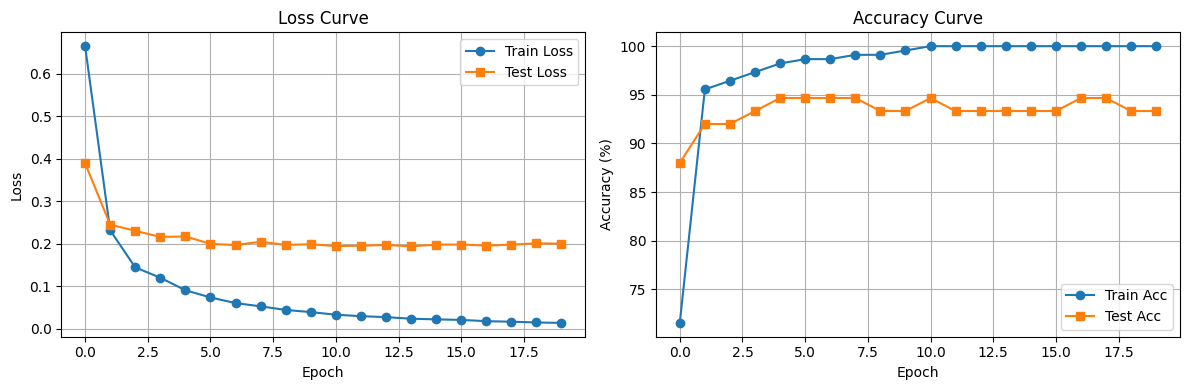

In [63]:
# 完整修正版本
import torch
from torch import nn
from tqdm.auto import tqdm

# 確保模型設定正確
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 重新設定模型（確保正確）
vit = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)

# 凍結預訓練參數
for param in vit.parameters():
    param.requires_grad = False

# 只訓練分類頭
vit.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=3)
)

# 確保分類頭的參數可以訓練
for param in vit.heads.parameters():
    param.requires_grad = True

vit.to(device)

# 檢查可訓練參數
trainable_params = sum(p.numel() for p in vit.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in vit.parameters())
print(f"可訓練參數: {trainable_params:,}")
print(f"總參數: {total_params:,}")

# 設定訓練參數
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.heads.parameters(), lr=0.001)  # 只優化分類頭
# 或者使用更小的學習率: lr=0.0001

epochs = 20
results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

print(f"開始訓練...")
print(f"訓練樣本數: {len(train_dataset)}")
print(f"測試樣本數: {len(test_dataset)}")
print(f"類別: {train_dataset.classes}")

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # =============== 訓練階段 ===============
    vit.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    train_pbar = tqdm(train_dataloader, desc="Training")
    for batch_idx, (X, y) in enumerate(train_pbar):
        X, y = X.to(device), y.to(device)

        # 前向傳播
        outputs = vit(X)
        loss = loss_fn(outputs, y)

        # 反向傳播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 計算統計
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += y.size(0)
        train_correct += (predicted == y).sum().item()

        # 更新進度條
        current_acc = 100. * train_correct / train_total
        train_pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{current_acc:.2f}%'
        })

    # 計算平均訓練指標
    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_correct / train_total

    # =============== 測試階段 ===============
    vit.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        test_pbar = tqdm(test_dataloader, desc="Testing")
        for X, y in test_pbar:
            X, y = X.to(device), y.to(device)

            outputs = vit(X)
            loss = loss_fn(outputs, y)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += y.size(0)
            test_correct += (predicted == y).sum().item()

            # 更新進度條
            current_acc = 100. * test_correct / test_total
            test_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.2f}%'
            })

    # 計算平均測試指標
    avg_test_loss = test_loss / len(test_dataloader)
    test_accuracy = test_correct / test_total

    # 儲存結果
    results["train_loss"].append(avg_train_loss)
    results["train_acc"].append(train_accuracy)
    results["test_loss"].append(avg_test_loss)
    results["test_acc"].append(test_accuracy)

    # 印出結果
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} ({100*train_accuracy:.2f}%)")
    print(f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.4f} ({100*test_accuracy:.2f}%)")

print("\n訓練完成！")

# 繪製訓練曲線
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 損失曲線
ax1.plot(results["train_loss"], label="Train Loss", marker='o')
ax1.plot(results["test_loss"], label="Test Loss", marker='s')
ax1.set_title("Loss Curve")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# 準確率曲線
ax2.plot([acc*100 for acc in results["train_acc"]], label="Train Acc", marker='o')
ax2.plot([acc*100 for acc in results["test_acc"]], label="Test Acc", marker='s')
ax2.set_title("Accuracy Curve")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()